# Deep Learning Project work

## Classification of Melanoma

notes: different pixel size, different colors (e.g. purple circle)


In [91]:
# Library 
library(keras)
library(tensorflow)
tf$version$VERSION  #2.6.5
library(tidyverse)
require(graphics)
library(randomForest)
library(grid)

[1] "2.6.5"


Attaching package: ‘grid’


The following object is masked from ‘package:imager’:

    depth




## Loading Function written by UM 

In [2]:
# Define utility functions ----
load_data <- function(base_path, type = 'train', image_size=64) { 
  
  path <- fs::path(base_path, type)
  img_ls<- fs::dir_ls(path, recurse = TRUE, type='file') 
  
  y_type <- rep('default', length(img_ls))
  X_type = array(dim=c(length(img_ls), image_size, image_size ,3L))
  
  loaded = 0
  for (idx in 1:length(img_ls)) {
    
    img_path <- img_ls[idx]
    type_folder <- stringr::str_extract(img_path, pattern="(melanoma|nevus|seborrheic_keratosis).ISIC_[0-9]{0,20}.jpg")
    type <- stringr::str_extract(type_folder, pattern="(melanoma|nevus|seborrheic_keratosis)")
    img <- keras::image_load(img_path, target_size = c(image_size,image_size))
    img.arr <- keras::image_to_array(img)
    X_type[idx,,,] = img.arr
    y_type[idx] <- type
    
    # Dummy code output 
    loaded = loaded + 1
    
  }
  print(paste0('Loaded:', path))
  return (list(X=X_type, y_label=as.factor(y_type), y_one_hot_encoded=to_categorical(as.integer(as.factor(y_type)) - 1 , num_classes = 3)))
}





In [ ]:
# Working on pre-trained VGG Dataset
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 1000){
  
  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
                              input_tensor = input_tensor, 
                              # MP: comment out next line, include succeeding line
                              #input_shape = normalize_shape(input_shape)
                              input_shape = input_shape, 
                              pooling = pooling, classes = as.integer(classes))
}


## Read in the data 


You need to link the [Kaggle dataset](https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/code) within the Kaggle "Add Data" snippet before proceeding with executing the next cell.

In [7]:
# Load datasets ----
base_path =  '../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions'
image_size = 64L

d_train = load_data(base_path = base_path, type='train',
              image_size = image_size)
X_train = d_train$X 
Y_train = d_train$y_one_hot_encoded # Classes one-hot-encoded
y_train = d_train$y_label

## Validation data
d_val = load_data(base_path = base_path, type='valid',
              image_size = image_size)
X_val = d_val$X 
Y_val = d_val$y_one_hot_encoded # Classes one-hot-encoded
y_val = d_val$y_label

## Test data
d_test = load_data(base_path = base_path, type='test',
              image_size = image_size)
X_test = d_test$X 
Y_test = d_test$y_one_hot_encoded # Classes one-hot-encoded
y_test = d_test$y_label

[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train"
[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid"
[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test"


In [ ]:
# Define and fit a CNN with dropout layers

In the next few cells you will define and train a CNN to classify the images into the 3  classes (melanoma|nevus|seborrheic_keratosis)



In [34]:
batch_size =  256##128## 64
nb_classes = 3
img_rows = image_size
img_cols = image_size
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

model <- keras_model_sequential() %>% 
  # convolutional part of the CNN
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%

  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_flatten() %>% 

  #fully connected part of the CNN
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(model)

Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_23 (Conv2D)                  (None, 64, 64, 16)              448         
________________________________________________________________________________
conv2d_22 (Conv2D)                  (None, 64, 64, 16)              2320        
________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D)     (None, 32, 32, 16)              0           
________________________________________________________________________________
conv2d_21 (Conv2D)                  (None, 32, 32, 32)              4640        
________________________________________________________________________________
conv2d_20 (Conv2D)                  (None, 32, 32, 32)              9248        
________________________________________________________________________________
max_po

In [35]:
# compile model and intitialize weights
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

`geom_smooth()` using formula 'y ~ x'



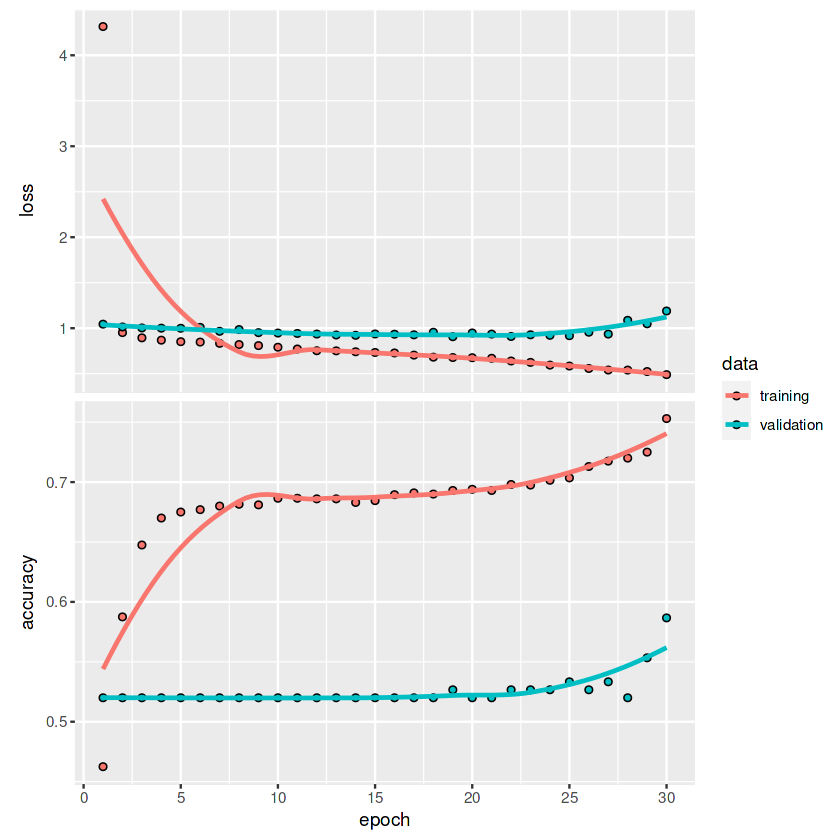

In [36]:
# train the model (can take 2-3 minuntes)
history <- model %>% fit(
  X_train, Y_train, 
  epochs = 30, batch_size=batch_size,
  verbose=0, validation_data = list(X_val, Y_val))
plot(history)

In [38]:
## Show model accuracy
accuracy <- model %>% evaluate(X_test, Y_test, verbose=0)

In [39]:
round(accuracy,2)

loss accuracy 
    0.89     0.67

In [40]:
accuracy

loss  accuracy 
0.8861693 0.6666667

### Probability model
Return which class had the highest probability

In [43]:
probability_model <- keras_model_sequential() %>%
  model() %>%
  layer_activation_softmax() %>%
  layer_lambda(tf$argmax)

In [47]:
probability_model(X_test)

tf.Tensor([112 369 589], shape=(3), dtype=int64)

melanoma|nevus|seborrheic_keratosis

## Seborrheic Keratosis Bilder

In [60]:
str(d_train)

List of 3
 $ X                : num [1:2000, 1:64, 1:64, 1:3] 26 26 193 129 149 218 1 1 17 1 ...
 $ y_label          : Factor w/ 3 levels "melanoma","nevus",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ y_one_hot_encoded: num [1:2000, 1:3] 1 1 1 1 1 1 1 1 1 1 ...


In [ ]:
file_list(../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train)

In [55]:
# initialize plot
op <- par(bg = "thistle")
plot(c(100, 250), c(100, 250), type = "n", axes = FALSE, xlab = "", ylab = "", main = "9 Sample Images of seborrheic_keratosis)

col = 100
imageId = 1

# loop thorugh sample images
for (i in 1:3) {   
    row = 100
    for (j in 1:3) {
       rasterImage(sk_ex/255,
              row, col, row + 50, col + 50)
       imageId = imageId + 1
       row = row + 52
    }   
    col = col + 52
}

ERROR: Error in parse(text = x, srcfile = src): <text>:3:87: unexpected INCOMPLETE_STRING
17:     col = col + 52
18: }
                                                                                          ^


## Identify miss-labeled images

In [41]:
predictions <- model %>%
  predict(X_test)  %>% 
  k_argmax() + 1 # Index shift python vs r

predictions <- as.array(predictions)
  
### Sanity check: Accuracy
(mean(as.integer(y_test) == predictions))



[1] 0.6666667

In [96]:
# Define model
features = base_model$output %>% layer_flatten()
model_feature <- keras_model(
  inputs = base_model$input, 
  outputs = features)
summary(model_feature)

# Compute new feature space
X_train_features = model_feature(X_train)
X_val_features = model_feature(X_val)
X_test_features = model_feature(X_test)

# Train random forest classifier
df_train = data.frame(
  y = y_train, # Factor with class definitions
  as.matrix(X_train_features)
)
df_test = data.frame(
  y = y_test, 
  as.matrix(X_test_features)
)

# Train random forest on baseline features
rf = randomForest(as.factor(y) ~ ., df_train)

# Predict class labels
pred_rf = predict(rf, df_test)

## Calculate prediction accuracy
acc_rf = mean(pred_rf == y_test)

Model: "model_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                [(None, 64, 64, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 64, 64, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 64, 64, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 32, 32, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 32, 32, 128)             73856       
________________________________________________________________________________
block2_conv

In [1]:
image_data_generator(
rotation_range = 20,
width_shift_range = 0.2,
height_shift_range = 0.2,
horizontal_flip = TRUE
) 

ERROR: Error in image_data_generator(rotation_range = 20, width_shift_range = 0.2, : could not find function "image_data_generator"
